In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image



import dense_correspondence_manipulation.utils.utils as utils
utils.add_dense_correspondence_to_python_path()

import dense_correspondence
from dense_correspondence.evaluation.evaluation import *
import dense_correspondence.correspondence_tools.correspondence_plotter as correspondence_plotter
import dense_correspondence.correspondence_tools.correspondence_finder as correspondence_finder
from dense_correspondence.correspondence_tools.correspondence_finder import random_sample_from_masked_image, pinhole_projection_image_to_world
from dense_correspondence.dataset.dense_correspondence_dataset_masked import ImageType
from dense_correspondence.network.dense_correspondence_network import DenseCorrespondenceNetwork
import dense_correspondence.evaluation.plotting as dc_plotting
import glob
from scipy import misc
import pickle
from os.path import basename, exists
import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--name',  type=str, default="thingiverse_multi_rgb_unit_16")
# parser.add_argument('--experiment', type=str, default="classification")
# parser.add_argument('--savefile', type=str, default="ycb_results.pkl")
# args = parser.parse_args()

utils.set_cuda_visible_devices([0]) # use this to manually set CUDA_VISIBLE_DEVICES

config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config',
                               'dense_correspondence', 'evaluation', 'evaluation.yaml')
config = utils.getDictFromYamlFilename(config_filename)
dce = DenseCorrespondenceEvaluation(config)
DCE = DenseCorrespondenceEvaluation
dcn = dce.load_network_from_config("thingiverse_multi_rgb_unit_16")
print("Loaded network. ")
dataset = dcn.load_training_dataset()
print("Loaded dataset. ")
camera_intrinsics = dataset.get_camera_intrinsics("elephant")

def match_index_and_norm_diff(query, features, cond=None):
    """
    Assumes that query and features both have shape (N, D).
    query: ndarray (D,)
    features: ndarray (N, D)
    """

    if cond is None:
        norm_diffs = np.sqrt(np.sum(np.square(features - query), axis=1))

    elif cond == "ppf":
        f1 = features[:, 1:]
        D = f1.shape[1]
        f2 = np.concatenate((f1[:, D//2:], f1[:, :D//2]), axis=1)

        norm_diffs1 = np.sqrt(np.sum(np.square(f1 - query[1:]), axis=1))
        norm_diffs2 = np.sqrt(np.sum(np.square(f2 - query[1:]), axis=1))
        norm_diffs = np.minimum(norm_diffs1, norm_diffs2)

        feature_cond = features[:, 0]
        query_cond = query[0]
        mask = np.logical_and(feature_cond > 5./7*query_cond, feature_cond < 9./7*query_cond).astype(np.float)
        norm_diffs = mask * norm_diffs + np.nan_to_num((1-mask) * float("inf") * np.ones(norm_diffs.shape))
    else:
        assert 1 == 0

    best_match_index = np.argmin(norm_diffs)
    best_match_diff = norm_diffs[best_match_index]
    result = np.array([best_match_index, best_match_diff])

    #         candidate_indices = np.argwhere(np.logical_and(ppfs[:,0] > 5/7*ppf_target[0], ppfs[:,0] < 9/7*ppf_target[0])).T[0]

    return result


def simple_match(f1, f2, cond=None):
    """
    Simple brute force matching between features1 and features2.
    f1: ndarray of shape (N, ... )
    f2: ndarray of shape (N, ....)
    fn: None, "ppf"
    Returns indices of matches. Also does some filtering
    to make sure that the best match of f1 is the best match of f2.
    """

    f1 = f1.reshape((f1.shape[0], -1))
    f2 = f2.reshape((f2.shape[0], -1))

    f1_matches = np.apply_along_axis(lambda x: match_index_and_norm_diff(x, f2, cond), 1, f1)
    f2_matches = np.apply_along_axis(lambda x: match_index_and_norm_diff(x, f1, cond), 1, f2)

    best_matches = []
    for i in range(f1_matches.shape[0]):
        norm_diff = f1_matches[i, 1]
        best_match_index = int(f1_matches[i, 0])
        if f2_matches[best_match_index, 0] == i: # If they're the best matches of each other
            best_matches.append((i, best_match_index, norm_diff))

    return best_matches


def run_dcn_on_image(dcn, dataset, img):
    """
    Run DCN on PIL img. use of dataset is a hack, just need to ge the descriptor image stats
    which actually just uses a constant for std and mean.
    """
    rgb_a_tensor = dataset.rgb_image_to_tensor(img)
    res_a = dcn.forward_single_image_tensor(rgb_a_tensor).data.cpu().numpy()
    descriptor_image_stats = dcn.descriptor_image_stats
    res_a_norm = dc_plotting.normalize_descriptor(res_a, descriptor_image_stats["mask_image"])
    return res_a_norm

def compute_PPF_feature(uv_A, uv_B, img, des, camera_intrinsics):
    """
    Computes PPF feature from uv_A and uv_B. These are in UV (openCV) format.
    Camera intrinsics should be in one of the first cells.

    img is the input "depth rgb" image. Bc it was generated with img = actual_depth / 0.2,
    the actual depth is img * 0.2

    Descriptor is [weight * distance, des_A...., desB....]
    # """
    # print(img.shape)
    # print(np.sum(img[:, :, 0] - img[:, :, 1]))
    #
    #
    # assert len(img.shape) == 2 # make sure that this is a depth image!

#     if uv_B[0] < uv_A[0]:
#         uv_A, uv_B = uv_B, uv_A
#     elif uv_B[0] == uv_A[0] and uv_B[1] < uv_A[1]:
#         uv_A, uv_B = uv_B, uv_A

    # !! HACK !!
    # NEED TO CHECK IF IT's 0-255 or 0-1
    depth_A = img[uv_A[1], uv_A[0]] / 255.
    depth_B = img[uv_B[1], uv_B[1]] / 255.
    des_A = des[uv_A[1], uv_A[0], :]
    des_B = des[uv_B[1], uv_B[0], :]

    pos_in_camera_frameA = pinhole_projection_image_to_world(uv_A, depth_A, camera_intrinsics.K)
    pos_in_camera_frameB = pinhole_projection_image_to_world(uv_B, depth_B, camera_intrinsics.K)

    distance = np.sqrt(np.sum((pos_in_camera_frameA - pos_in_camera_frameB)**2))
#     dist = lambda x, y: np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
#     distance = dist(uv_A, uv_B)
    ppf = np.concatenate((np.array([distance]), des_A, des_B))
    des_distance = np.sqrt(np.sum((des_A - des_B)**2))
    return ppf, des_distance


def generate_PPF_samples(img, des, mask, num_samples=5):
    """Generate np.array of shape (N**2 x PPF_dim) sample features.
    Returns list of (UV_A, UV_B) samples.
    """
    dist = lambda x, y: np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    mask = mask[:, :, 0].astype(np.int)
    sampled_idx_list = random_sample_from_masked_image(mask, num_samples)

    # If the list is empty, return an empty list
    if len(sampled_idx_list) == 0:
        return dataframe_list

    ppf_lst = []
    coord_lst = []
    des_distances = []

    for i in range(num_samples):
        for j in range(i+1, num_samples):
            uv_A = [sampled_idx_list[1][i], sampled_idx_list[0][i]]
            uv_B = [sampled_idx_list[1][j], sampled_idx_list[0][j]]
            if dist(uv_A, uv_B) > 10: # Basic: Increase pixel distance. # !!! this might be a reason for failure for small objects
#                                       # TODO: Increase physical spatial difference
#                                       # TODO: Increase feature space difference
                coord_lst.append((uv_A, uv_B))
                ppf_feature, des_distance = compute_PPF_feature(uv_A, uv_B, img, des, camera_intrinsics)
                des_distances.append(des_distance)
                ppf_lst.append(ppf_feature)

    ppf_lst = np.array(ppf_lst)
    coord_lst = np.array(coord_lst)
    des_distances = np.array(des_distances)
    best_distances = np.argsort(des_distances)[-(len(des_distances)//3):] # !!!!! HACK
    return ppf_lst[best_distances], coord_lst[best_distances]

# key: "banana", value: [('object1', norm), ('object2', norm)]
results = {}
num_in_top_5 = 0
# target_files = sorted(glob.glob("/nfs/diskstation/objects/meshes/ycb/*"))
# all_heap_paths = sorted(glob.glob("/nfs/diskstation/objects/meshes/ycb/*"))

target_files = sorted(glob.glob("images/ycb_thingiverse_targets/*"))
# all_heap_paths = sorted(glob.glob("images/ycb_thingiverse_heap/*"))
all_heap_paths = target_files
target_ppfs = {}

def classification_from_heap(heap_name):
    """
    For every heap image, get the top N matches from target image.
    """
    global num_in_top_5
    print("===========================ON HEAP {}========================".format(heap_name))
    heap_img = Image.open("images/ycb_thingiverse_heap/{}/rgb.png".format(heap_name)).convert('RGB')
    heap_depth = misc.imread("images/ycb_thingiverse_heap/{}/depth_unscaled.png".format(heap_name))
    heap_mask = np.load("images/ycb_thingiverse_heap/{}/mask.npy".format(heap_name)).astype(np.bool)
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    ppf_heap, coord_t = generate_PPF_samples(heap_depth, heap_descriptors, heap_mask, 100)
    cur_results = []

#     for mesh_path in target_files:
    if True:
#         target_name = basename(mesh_path).split(".")[0]
        target_name = heap_name
        print("Testing target:", target_name)
        smallest_norm = float('inf')

        cur_ppfs = []

        for i in range(6):
            if target_name in target_ppfs:
                ppf_t = target_ppfs[target_name][i]
            else:
                target_mask = np.load("images/ycb_thingiverse_targets/{}/mask_{}.npy".format(target_name, i)).astype(np.bool)
                target_depth = misc.imread("images/ycb_thingiverse_targets/{}/depth_unscaled_{}.png".format(target_name, i))
                target_img = Image.open("images/ycb_thingiverse_targets/{}/rgb_{}.png".format(target_name, i)).convert('RGB')
                target_descriptors = run_dcn_on_image(dcn, dataset, target_img)

                ppf_t, coords = generate_PPF_samples(target_depth, target_descriptors, target_mask, 100)
                cur_ppfs.append(ppf_t)

            # Generate ppfs for each object in the heap
            best_matches_lst = simple_match(ppf_t, ppf_heap, cond="ppf")

            print("# of possible matches: ", len(best_matches_lst))
            kp1, kp2, matches = [], [], []
            diam = 0.01

            for x, match in enumerate(best_matches_lst):
                i, j, dist = match    
                kp1.append(cv2.KeyPoint(coord_t[i, 0, 0], coord_t[i, 0, 1], diam))
                kp1.append(cv2.KeyPoint(coord_t[i, 1, 0], coord_t[i, 1, 1], diam))
                kp2.append(cv2.KeyPoint(coords[j, 0, 0], coords[j, 0, 1], diam))
                kp2.append(cv2.KeyPoint(coords[j, 1, 0], coords[j, 1, 1], diam))
                matches.append(cv2.DMatch(x*2, x*2, dist))
                matches.append(cv2.DMatch(x*2+1, x*2+1, dist))

            matches = sorted(matches, key = lambda x:x.distance)
            print("MATCH norm: ", np.mean([x.distance for x in matches[:5]]))

            img3 = cv2.drawMatches(np.array(target_img),kp1,np.array(heap_img),kp2,matches[:5], None, flags=2)
            
            plt.figure()
            plt.imshow(target_mask.astype(np.float))
            
            plt.figure(figsize = (20, 10))
            plt.imshow(img3)
            plt.show()
        
            if len(best_matches_lst) > 0:
                distances = [match[2] for match in best_matches_lst]
                distances = np.array(sorted(distances)[:10])
                smallest_norm = min(smallest_norm, np.mean(distances))
        cur_results.append((target_name, smallest_norm))
        if target_name not in target_ppfs:
            target_ppfs[target_name] = cur_ppfs

        # print(cur_results)
    cur_results = sorted(cur_results, key = lambda x: x[1])
    results[heap_name] = cur_results
#     with open(args.savefile, 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(cur_results)
    # for i in range(5):
    #     if cur_results[i][0] == heap_name:
    #         num_in_top_5 += 1
    #         break

def heapsearch_from_target(target_name):
    target_ppfs = []
    cur_results = []
    print("===========================ON TARGET {}========================".format(target_name))

    for i in range(6):
        target_mask = np.load("images/ycb_thingiverse_targets/{}/mask_{}.npy".format(target_name, i)).astype(np.bool)
        target_depth = misc.imread("images/ycb_thingiverse_targets/{}/depth_unscaled_{}.png".format(target_name, i))
        target_img = Image.open("images/ycb_thingiverse_targets/{}/rgb_{}.png".format(target_name, i)).convert('RGB')
        target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
        ppf_t, _ = generate_PPF_samples(target_depth, target_descriptors, target_mask, 100)
        target_ppfs.append(ppf_t)

    for heap_path in all_heap_paths:
        print("Testing heap: {}".format(heap_path))
        heap_name = basename(heap_path).split(".")[0]
        heap_img = Image.open("images/ycb_thingiverse_heap/{}/rgb.png".format(heap_name)).convert('RGB')
        heap_depth = misc.imread("images/ycb_thingiverse_heap/{}/depth_unscaled.png".format(heap_name))

        heap_mask = np.load("images/ycb_thingiverse_heap/{}/mask.npy".format(heap_name)).astype(np.bool)
        heap = np.array(heap_img)
        heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
        ppf_heap, _ = generate_PPF_samples(heap_depth, heap_descriptors, heap_mask, 100)

        smallest_norm = float('inf')
        for i in range(6):
            ppf_t = target_ppfs[i]
            best_matches_lst = simple_match(ppf_t, ppf_heap, cond="ppf")

            if len(best_matches_lst) > 0:
                distances = [match[2] for match in best_matches_lst]
                distances = np.array(sorted(distances)[:10])
                smallest_norm = min(smallest_norm, np.mean(distances))
        cur_results.append((heap_name, smallest_norm))
    results[target_name] = sorted(cur_results, key = lambda x: x[1])
    with open(args.savefile, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


# if args.experiment == "classification":
#     print("Running classification")
#     for heap_path in all_heap_paths:
#         heap_name = basename(heap_path)
#         classification_from_heap(heap_name)
# elif args.experiment == "heapsearch":
#     print("Running heapsearch")
#     for target_path in target_files:
#         target_name = basename(target_path)
#         heapsearch_from_target(target_name)


setting CUDA_VISIBLE_DEVICES =  0,
Loaded network. 
Using SpartanDataset:
   - in train mode
   - number of scenes 126
   - total images:     78246
Loaded dataset. 


===========================ON HEAP duckie_2336973========================
normalizing descriptor norm


/home/davidtseng/pytorch-dense-correspondence/env/lib/python2.7/site-packages/ipykernel_launcher.py:206: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


('Testing target:', 'duckie_2336973')
normalizing descriptor norm


/home/davidtseng/pytorch-dense-correspondence/env/lib/python2.7/site-packages/ipykernel_launcher.py:227: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/davidtseng/pytorch-dense-correspondence/env/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in multiply


('# of possible matches: ', 15)
('MATCH norm: ', 0.9513304233551025)


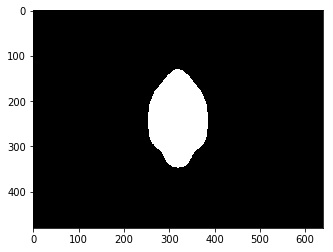

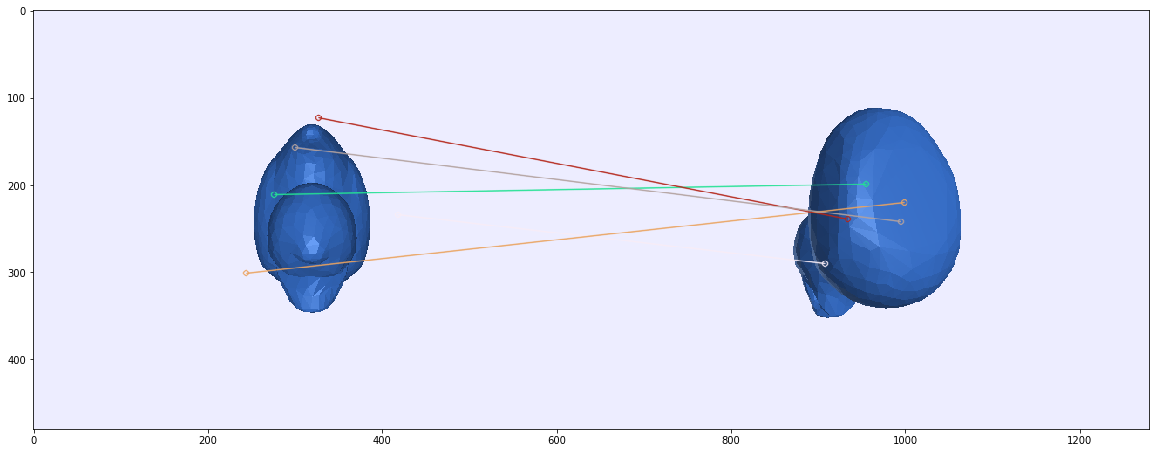

normalizing descriptor norm
('# of possible matches: ', 18)
('MATCH norm: ', 0.6252295255661011)


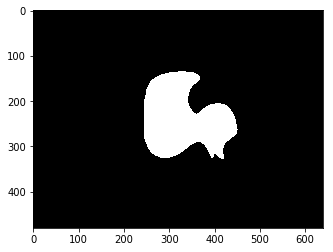

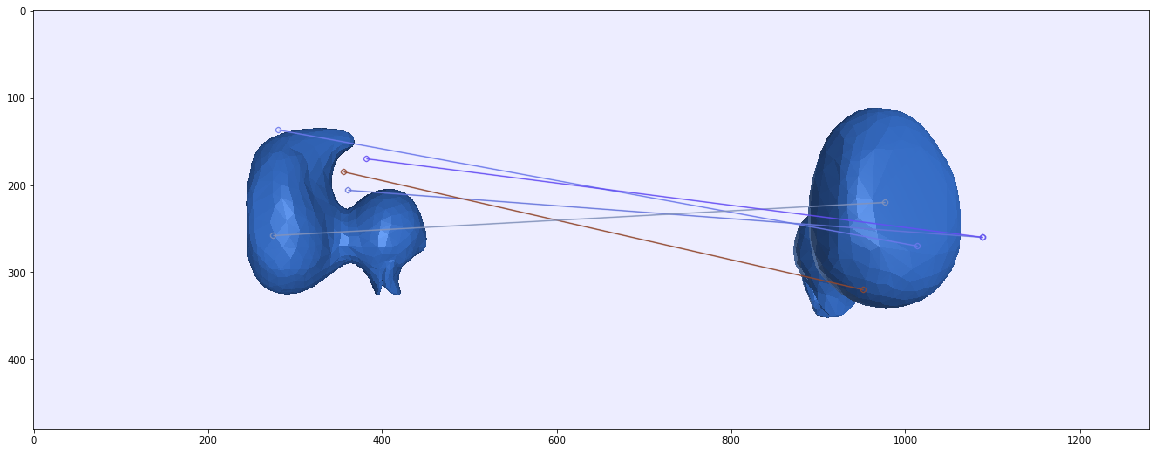

normalizing descriptor norm
('# of possible matches: ', 22)
('MATCH norm: ', 0.2719350516796112)


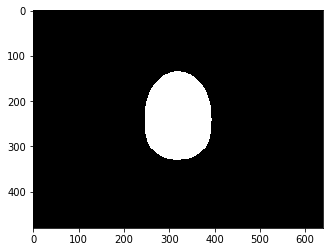

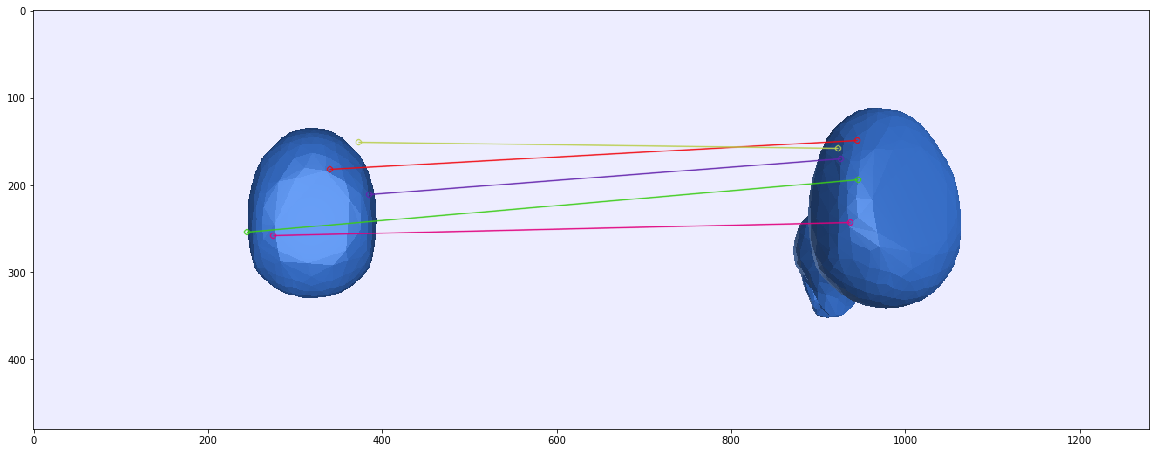

normalizing descriptor norm
('# of possible matches: ', 20)
('MATCH norm: ', 0.4055602490901947)


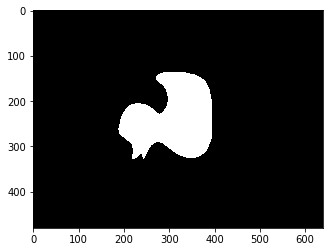

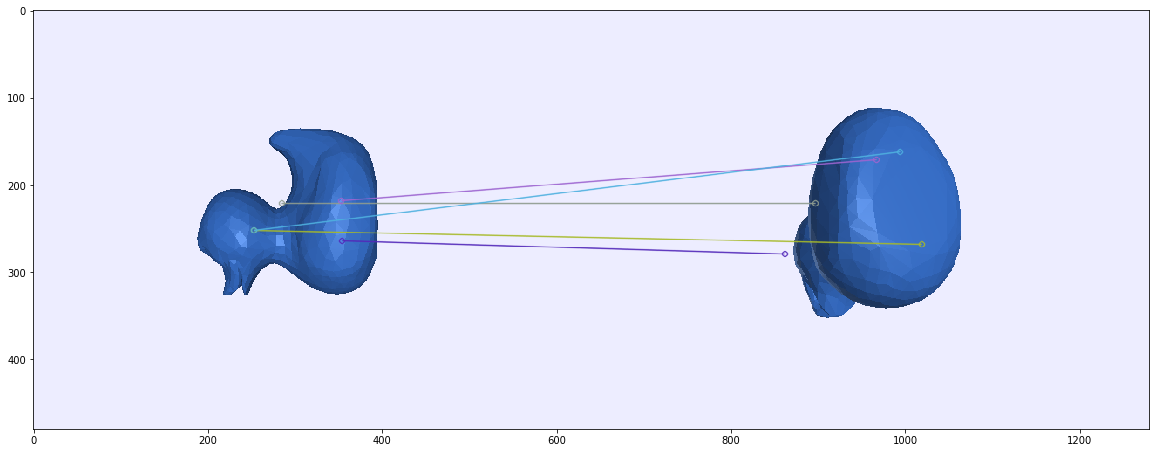

normalizing descriptor norm
('# of possible matches: ', 12)
('MATCH norm: ', 0.5114711284637451)


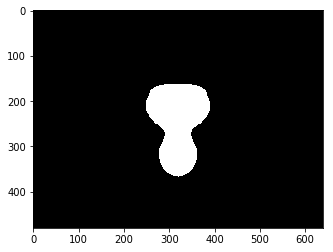

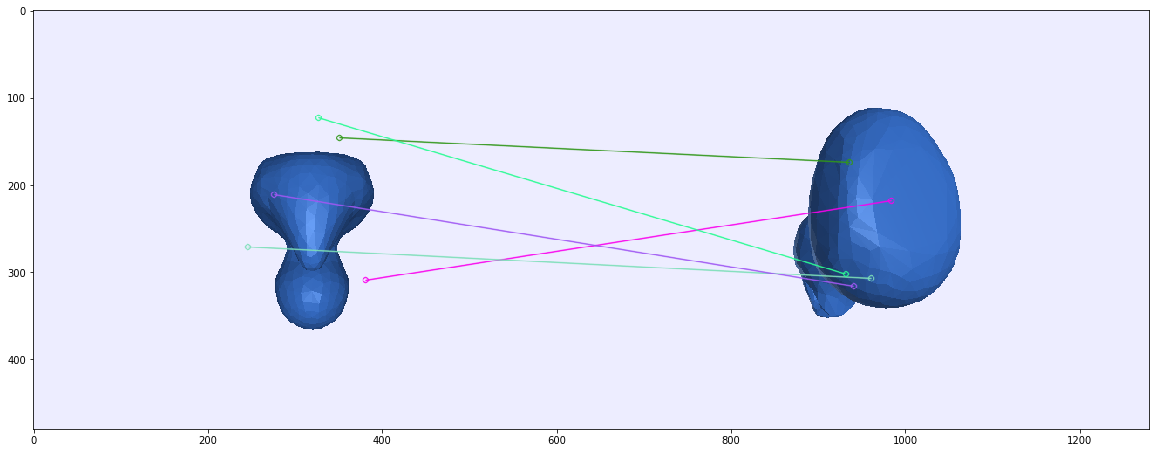

normalizing descriptor norm
('# of possible matches: ', 6)
('MATCH norm: ', 0.8669538736343384)


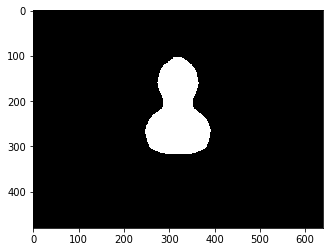

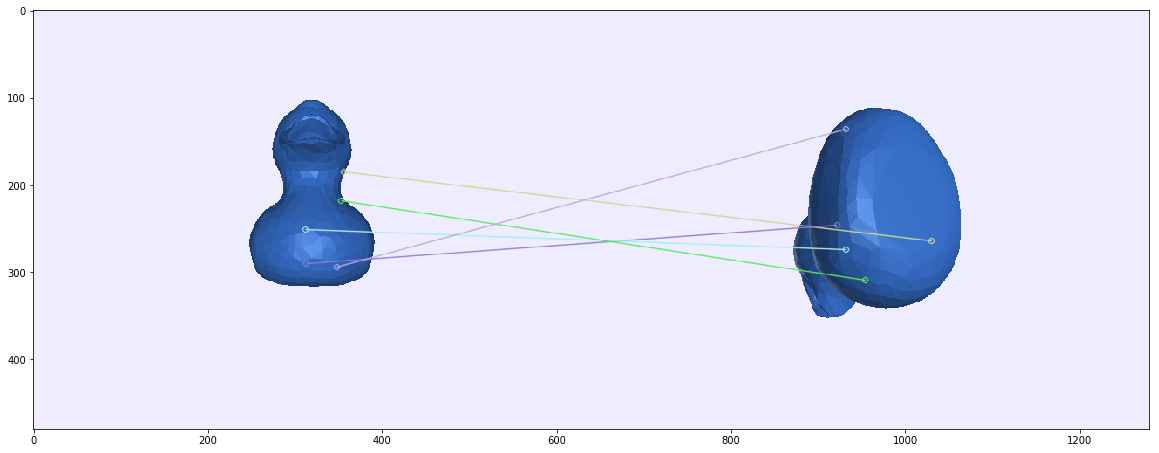

[('duckie_2336973', 0.3171128042315513)]


In [6]:
classification_from_heap("duckie_2336973")